## 1.환경 설정

### (1) 라이브러리 로딩

In [1]:
import numpy as np
import random
import os

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as spst
import joblib

from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, KFold
from sklearn.metrics import *
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import optuna
import warnings
warnings.filterwarnings(action='ignore')

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

### (2) 데이터 로딩

In [2]:
train_path = 'open/train.csv'
test_path = 'open/test.csv'
sub_path = 'open/sample_submission.csv'

train = pd.read_csv(train_path)
test = pd.read_csv(test_path)
sub = pd.read_csv(sub_path)

In [3]:
train.head()

,ID,Age,Gender,Education_Status,Employment_Status,Working_Week (Yearly),Industry_Status,Occupation_Status,Race,Hispanic_Origin,...,Citizenship,Birth_Country,Birth_Country (Father),Birth_Country (Mother),Tax_Status,Gains,Losses,Dividends,Income_Status,Income
0,TRAIN_00000,63,M,Middle (7-8),Full-Time,4,Social Services,Services,White,All other,...,Native,US,US,US,Nonfiler,0,0,0,Unknown,425
1,TRAIN_00001,37,M,Associates degree (Vocational),Full-Time,52,Entertainment,Services,White,All other,...,Native,US,US,US,Single,0,0,0,Under Median,0
2,TRAIN_00002,58,F,High graduate,Full-Time,52,Manufacturing (Non-durable),Admin Support (include Clerical),Black,All other,...,Native,US,US,US,Married Filling Jointly both under 65 (MFJ),3411,0,0,Under Median,860
3,TRAIN_00003,44,M,High graduate,Full-Time,52,Retail,Technicians & Support,White,All other,...,Native,US,US,US,Single,0,0,0,Under Median,850
4,TRAIN_00004,37,F,High graduate,Full-Time,52,Retail,Sales,White,All other,...,Native,US,US,US,Head of Household (HOH),0,0,0,Unknown,570


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   ID                      20000 non-null  object
 1   Age                     20000 non-null  int64 
 2   Gender                  20000 non-null  object
 3   Education_Status        20000 non-null  object
 4   Employment_Status       20000 non-null  object
 5   Working_Week (Yearly)   20000 non-null  int64 
 6   Industry_Status         20000 non-null  object
 7   Occupation_Status       20000 non-null  object
 8   Race                    20000 non-null  object
 9   Hispanic_Origin         20000 non-null  object
 10  Martial_Status          20000 non-null  object
 11  Household_Status        20000 non-null  object
 12  Household_Summary       20000 non-null  object
 13  Citizenship             20000 non-null  object
 14  Birth_Country           20000 non-null  object
 15  Bi

In [5]:
train.isna().sum()

ID                        0
Age                       0
Gender                    0
Education_Status          0
Employment_Status         0
Working_Week (Yearly)     0
Industry_Status           0
Occupation_Status         0
Race                      0
Hispanic_Origin           0
Martial_Status            0
Household_Status          0
Household_Summary         0
Citizenship               0
Birth_Country             0
Birth_Country (Father)    0
Birth_Country (Mother)    0
Tax_Status                0
Gains                     0
Losses                    0
Dividends                 0
Income_Status             0
Income                    0
dtype: int64

In [6]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,20000.0,35.63250,17.994414,0.0,23.0,34.0,47.0,90.0
Working_Week (Yearly),20000.0,34.94305,22.254592,0.0,7.0,52.0,52.0,52.0
Gains,20000.0,383.12950,4144.247487,0.0,0.0,0.0,0.0,99999.0
Losses,20000.0,40.20215,279.182677,0.0,0.0,0.0,0.0,4356.0
Dividends,20000.0,123.45145,1206.949429,0.0,0.0,0.0,0.0,45000.0
Income,20000.0,554.56525,701.553155,0.0,0.0,500.0,875.0,9999.0


## 2. 데이터 탐색

In [7]:
list(train)

['ID',
 'Age',
 'Gender',
 'Education_Status',
 'Employment_Status',
 'Working_Week (Yearly)',
 'Industry_Status',
 'Occupation_Status',
 'Race',
 'Hispanic_Origin',
 'Martial_Status',
 'Household_Status',
 'Household_Summary',
 'Citizenship',
 'Birth_Country',
 'Birth_Country (Father)',
 'Birth_Country (Mother)',
 'Tax_Status',
 'Gains',
 'Losses',
 'Dividends',
 'Income_Status',
 'Income']

### 수치형 단변량

In [8]:
def eda_num(features, train):
    plt.figure(figsize=(9, 15))
    for i in range(len(features)):
        plt.subplot(6, 2, (2 * i) + 1)
        sns.histplot(x = train[features[i]], bins=30, kde=True)
        plt.subplot(6, 2, (2 * i) + 2)
        sns.boxplot(x = train[features[i]])

    plt.tight_layout()
    plt.show()

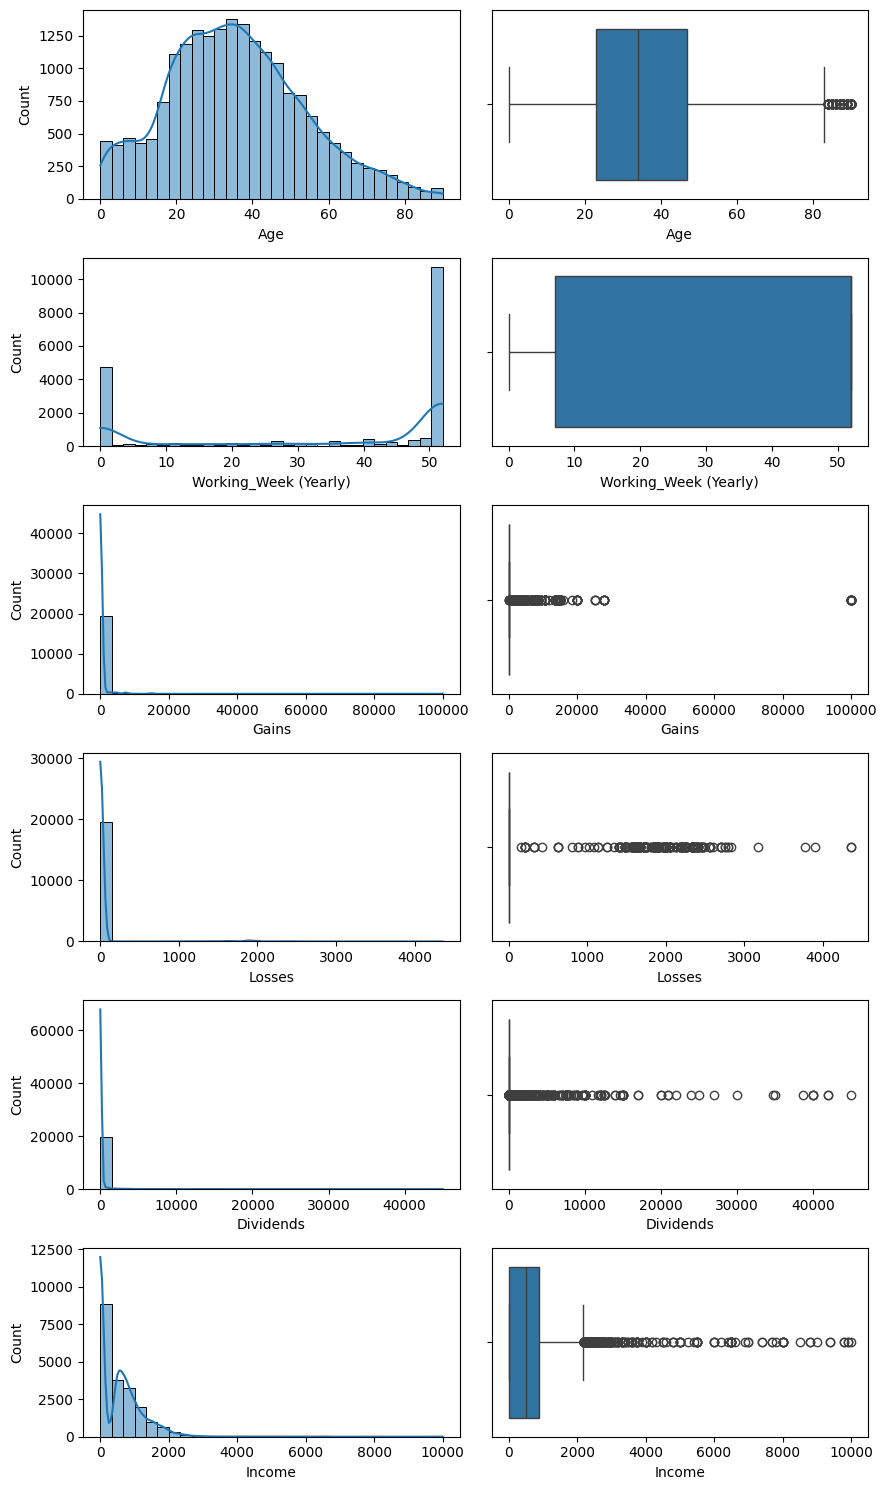

In [9]:
num_features = ['Age', 'Working_Week (Yearly)', 'Gains', 'Losses', 'Dividends', 'Income']

eda_num(num_features, train)

- 'Gains', 'Losses', 'Dividends' : 0의 수가 너무 많음
- Income : 거의 0 ~ 1000에 분포

### 범주형 단변량

In [10]:
def eda_cat(features, train):
    # plt.figure(figsize=(15, 15))
    for i in range(len(features)):
        print(train[features[i]].value_counts())
        print('=' * 60)
    #     plt.subplot(4, 4, i + 1)
    #     sns.countplot(x = train[features[i]])

    # plt.tight_layout()
    # plt.show()

In [11]:
cat_features = ['Gender', 'Education_Status', 'Employment_Status', 'Industry_Status', 
                'Occupation_Status', 'Race', 'Hispanic_Origin', 'Martial_Status', 'Household_Status', 
                'Household_Summary', 'Citizenship', 'Birth_Country', 'Birth_Country (Father)', 
                'Birth_Country (Mother)', 'Tax_Status', 'Income_Status']

eda_cat(cat_features, train)

Gender
F    10472
M     9528
Name: count, dtype: int64
Education_Status
High graduate                     6494
College                           3794
Children                          2208
Bachelors degree                  1956
High Junior                        820
High Sophomore                     799
Associates degree (Vocational)     741
Associates degree (Academic)       609
High Freshman                      555
Middle (7-8)                       548
Masters degree                     505
Elementary (5-6)                   317
High Senior                        242
Elementary (1-4)                   150
Professional degree                111
Doctorate degree                    87
Kindergarten                        64
Name: count, dtype: int64
Employment_Status
Children or Armed Forces         11142
Full-Time                         6588
Not Working                       1221
Choice Part-Time                   593
Part-Time (Usually Part-Time)      158
Seeking Full-Time         

- Occupation_Status, Hispanic_Origin, Birth_Country (Father), Birth_Country (Mother), Income_Status -> Unknown이나 다른 값들 처리 필요

In [14]:
train.groupby('Income_Status', as_index=False)['Income'].mean() # Ubknown -> Under Median

,Income_Status,Income
0,Over Median,941.084125
1,Under Median,537.030294
2,Unknown,545.810820


In [17]:
train.groupby('Occupation_Status', as_index=False)['Income'].mean() # Unknown, Armed Forces 삭제 필요

,Occupation_Status,Income
0,Admin Support (include Clerical),750.374677
1,Armed Forces,0.000000
2,Craft & Repair,986.415730
3,Farming & Forestry & Fishing,477.922297
4,Handlers/Cleaners,655.152927
5,Machine Operators & Inspectors,802.055676
6,Management,619.179118
7,Private Household Services,420.857143
8,Professional,884.705645
9,Protective Services,823.511538


In [18]:
train.groupby('Hispanic_Origin', as_index=False)['Income'].mean() # Do not know, NA 최빈값으로

,Hispanic_Origin,Income
0,All other,574.993697
1,Central or South American,356.089231
2,Chicano,644.925926
3,Cuban,370.802632
4,Do not know,268.090909
5,Mexican (Mexicano),395.666667
6,Mexican-American,420.946483
7,NA,247.881356
8,Other Spanish,381.213930
9,Puerto Rican,385.090535


In [21]:
train.groupby('Birth_Country (Father)', as_index=False)['Income'].mean() # Unknown 최빈값으로

,Birth_Country (Father),Income
0,Cambodia,381.153846
1,Canada,541.609375
2,China,598.246377
3,Columbia,268.666667
4,Cuba,339.948718
5,Dominican-Republic,300.212121
6,Ecuador,474.523810
7,El-Salvador,404.927711
8,England,604.797101
9,France,477.000000


In [23]:
train.groupby('Birth_Country (Mother)', as_index=False)['Income'].mean() # Unknown 최빈값으로

,Birth_Country (Mother),Income
0,Cambodia,341.363636
1,Canada,618.144654
2,China,653.783333
3,Columbia,242.000000
4,Cuba,337.287671
5,Dominican-Republic,324.880000
6,Ecuador,499.431818
7,El-Salvador,357.666667
8,England,678.000000
9,France,400.520000


### 수치형 이변량

In [65]:
def eda_num_num(num_cols, target, data):
    print('\n<<Numerical cols -> target>>\n')
    plt.figure(figsize = (8, 18))
    for i in range(len(num_cols)):
        plt.subplot(5, 1, i + 1)
        sns.scatterplot(x = num_cols[i], y = target, data = data)
    plt.show()
    
    corr_matrix = data.corr(numeric_only=True)
    sns.heatmap(corr_matrix, annot = True, cmap = 'Blues', cbar = False, square = True, fmt = '.2f', annot_kws = {'size' : 8})
    plt.show()


<<Numerical cols -> target>>



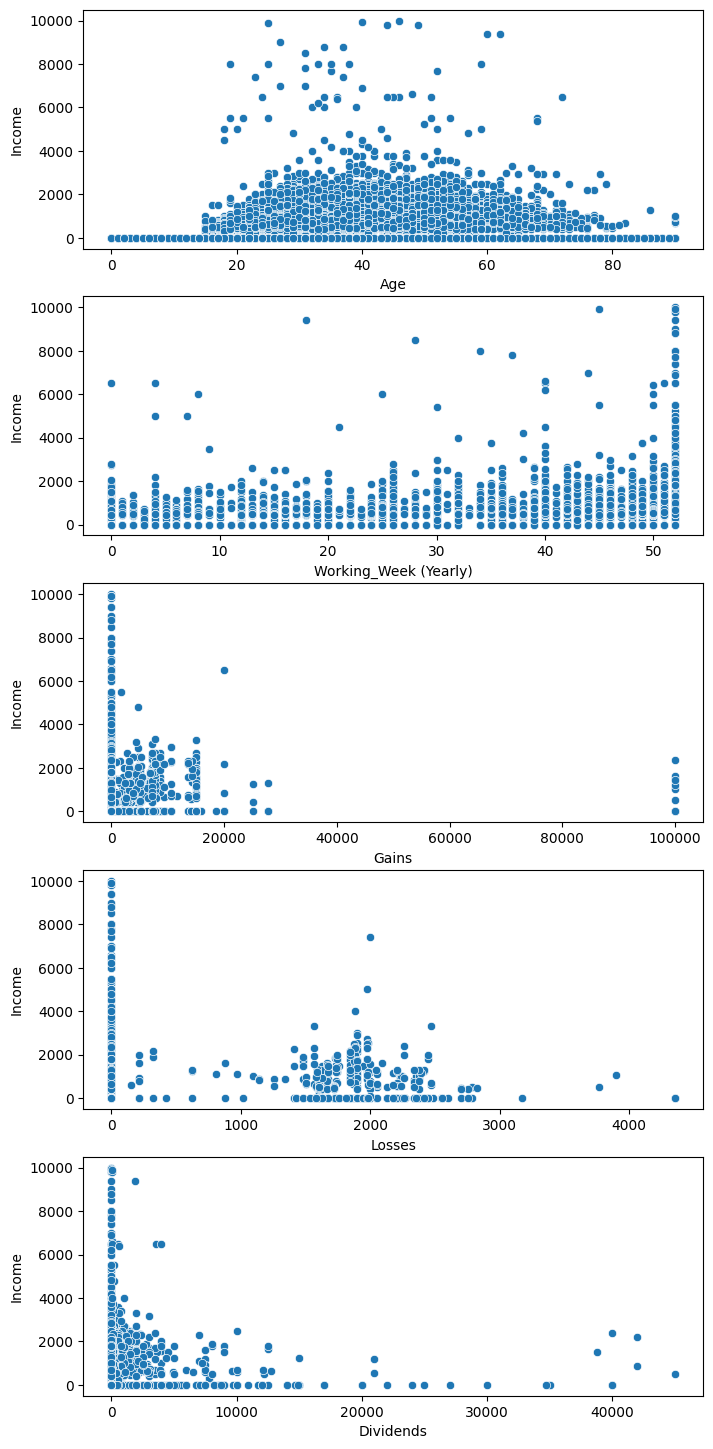

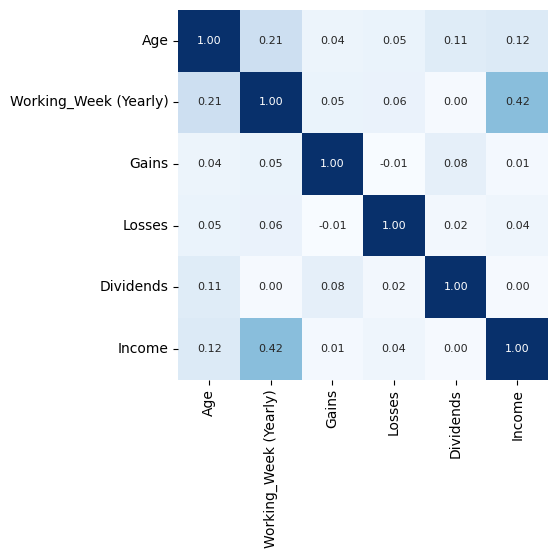

In [66]:
num_features = ['Age', 'Working_Week (Yearly)', 'Gains', 'Losses', 'Dividends']
eda_num_num(num_features, target, train)

Working_Week 유의미

### 범주형 이변량

In [28]:
def eda_2_cn_ttest(df, var, target):
    # Barplot 그리기
    plt.figure(figsize=(12, 8))
    sns.barplot(x=var, y=target, data=df)
    plt.grid()
    plt.show()
    
    # t-test 분석 수행
    groups = [df.loc[df[var] == i, target] for i in sorted(df[var].unique())]
    t_value, p_value = spst.ttest_ind(*groups)
    
    # 결과 출력
    print(f'T-test result for {var}: t-value: {t_value}, p-value: {p_value}')
    
def eda_2_cn_anova(df, var, target):
    # Barplot 그리기
    plt.figure(figsize=(12, 8))
    sns.barplot(x=var, y=target, data=df)
    plt.grid()
    plt.show()
    
    # ANOVA 분석 수행
    groups = [df.loc[df[var] == i, target] for i in sorted(df[var].unique())]
    f_statistic, p_value = spst.f_oneway(*groups)
    
    # 결과 출력
    print(f'ANOVA result for {var}: F-statistic: {f_statistic}, p-value: {p_value}')

In [26]:
cat_features = ['Gender', 'Education_Status', 'Employment_Status', 'Industry_Status', 
                'Occupation_Status', 'Race', 'Hispanic_Origin', 'Martial_Status', 'Household_Status', 
                'Household_Summary', 'Citizenship', 'Birth_Country', 'Birth_Country (Father)', 
                'Birth_Country (Mother)', 'Tax_Status', 'Income_Status']
target = 'Income'

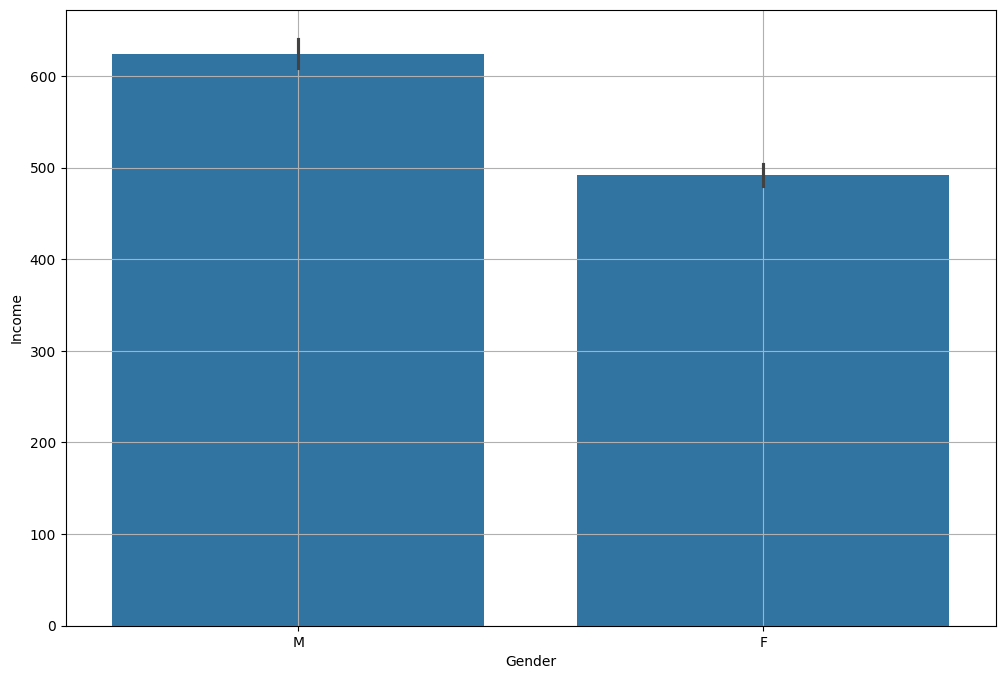

T-test result for Gender: t-value: -13.336700631450782, p-value: 2.107161980488648e-40


In [29]:
feature = 'Gender'

eda_2_cn_ttest(train, feature, target)

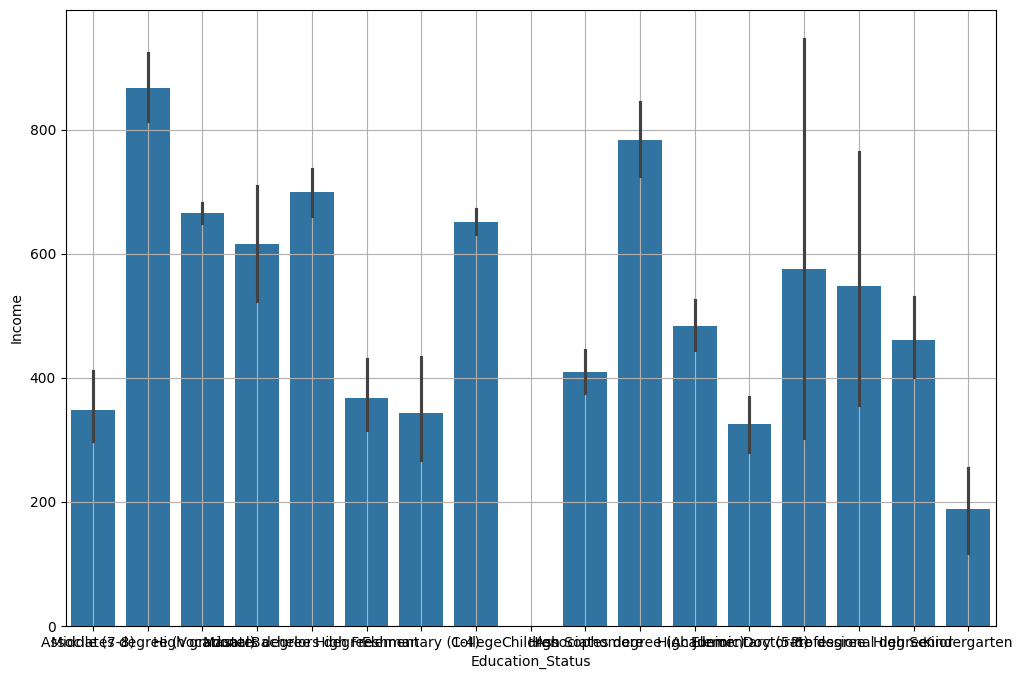

ANOVA result for Education_Status: F-statistic: 147.40546739713534, p-value: 0.0


In [30]:
feature = 'Education_Status'

eda_2_cn_anova(train, feature, target)

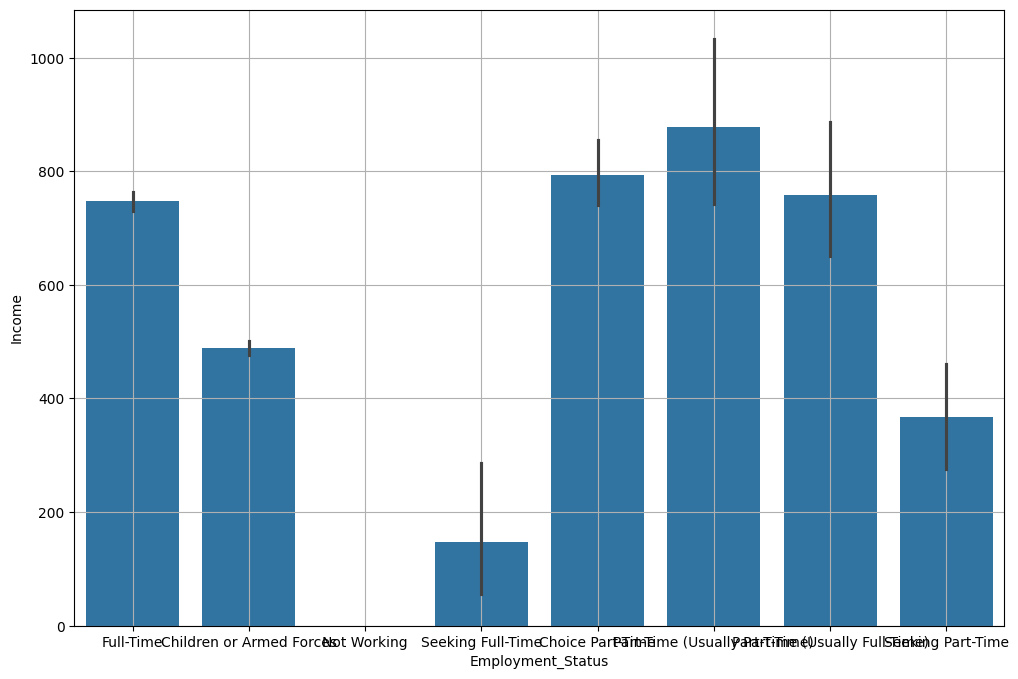

ANOVA result for Employment_Status: F-statistic: 234.03000546169528, p-value: 0.0


In [31]:
feature = 'Employment_Status'

eda_2_cn_anova(train, feature, target)

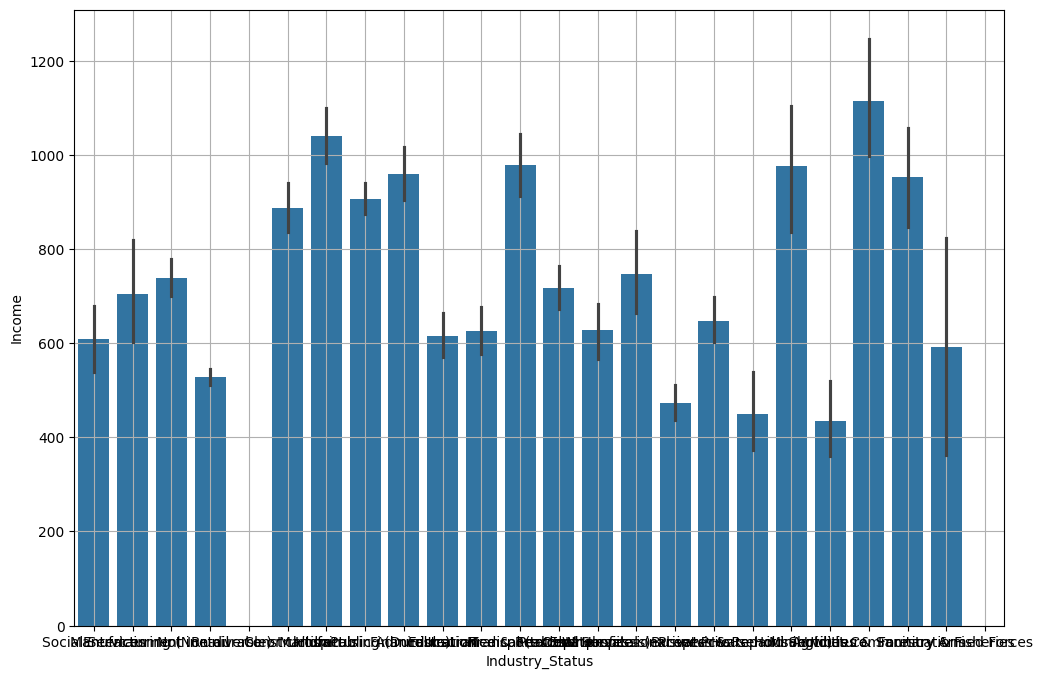

ANOVA result for Industry_Status: F-statistic: 277.5117195802549, p-value: 0.0


In [32]:
feature = 'Industry_Status'

eda_2_cn_anova(train, feature, target)

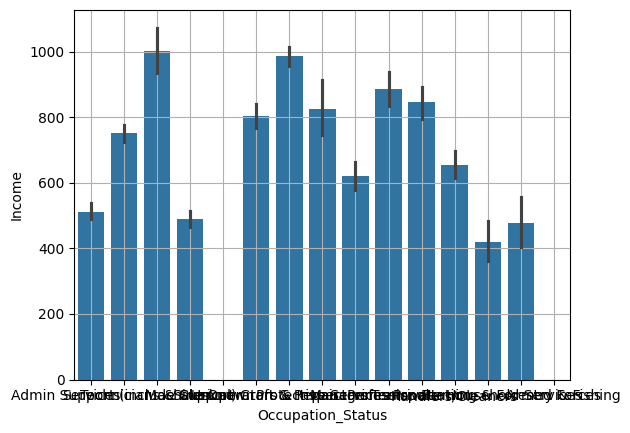

ANOVA result for Occupation_Status: F-statistic: 449.98168427453436, p-value: 0.0


In [81]:
feature = 'Occupation_Status'

eda_2_cn_anova(train, feature, target)

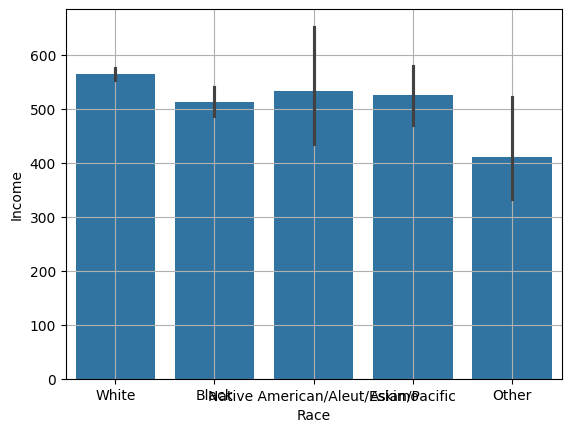

ANOVA result for Race: F-statistic: 5.9611017018350445, p-value: 8.633695567665494e-05


In [82]:
feature = 'Race'

eda_2_cn_anova(train, feature, target)

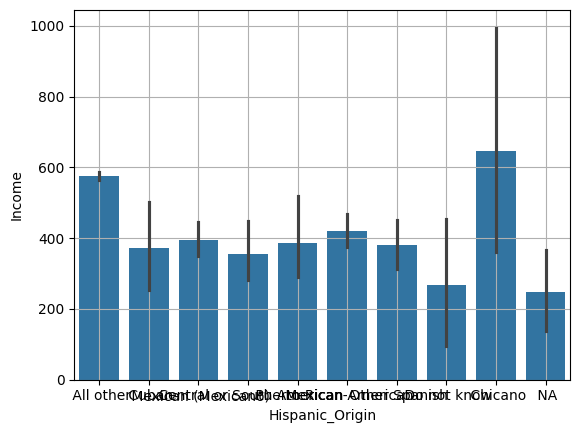

ANOVA result for Hispanic_Origin: F-statistic: 16.094468361141825, p-value: 1.3005330906679843e-26


In [83]:
feature = 'Hispanic_Origin'

eda_2_cn_anova(train, feature, target)

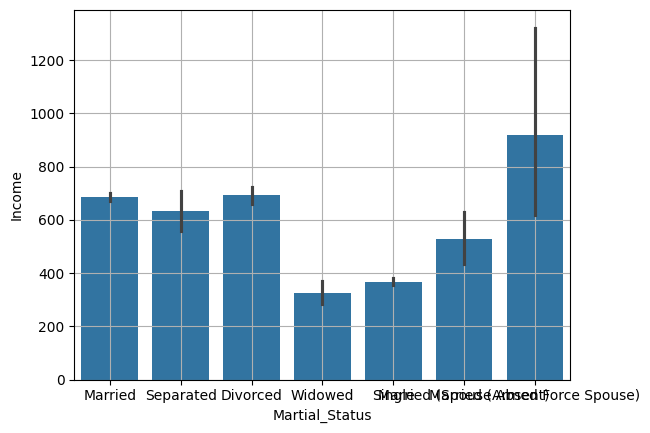

ANOVA result for Martial_Status: F-statistic: 180.82776239960836, p-value: 4.9710180670889395e-225


In [84]:
feature = 'Martial_Status'

eda_2_cn_anova(train, feature, target)

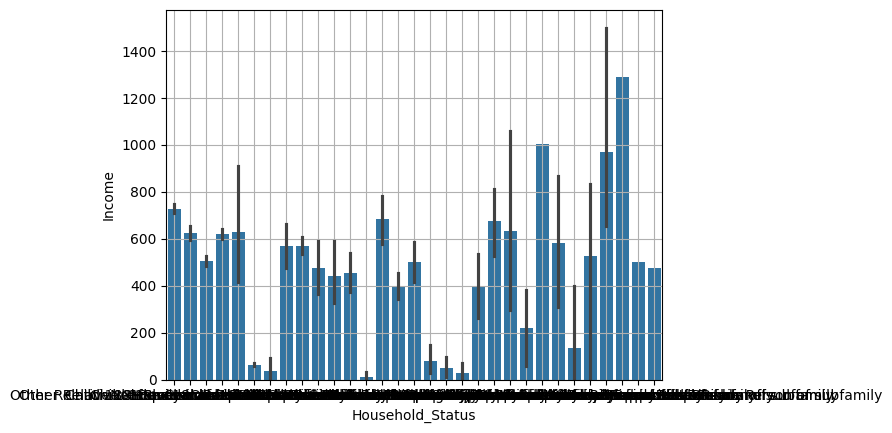

ANOVA result for Household_Status: F-statistic: 70.51007546591624, p-value: 0.0


In [85]:
feature = 'Household_Status'

eda_2_cn_anova(train, feature, target)

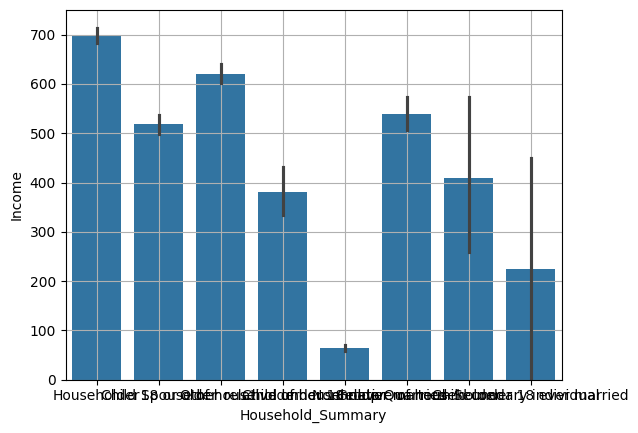

ANOVA result for Household_Summary: F-statistic: 277.01112940381796, p-value: 0.0


In [86]:
feature = 'Household_Summary'

eda_2_cn_anova(train, feature, target)

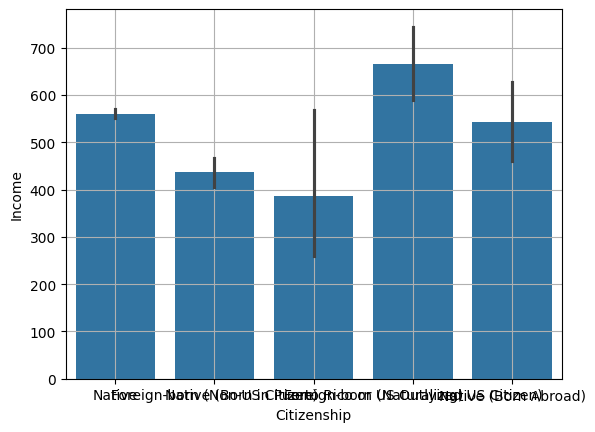

ANOVA result for Citizenship: F-statistic: 14.822631321735864, p-value: 4.2598707049981885e-12


In [87]:
feature = 'Citizenship'

eda_2_cn_anova(train, feature, target)

In [88]:
cat_features

['Gender',
 'Education_Status',
 'Employment_Status',
 'Industry_Status',
 'Occupation_Status',
 'Race',
 'Hispanic_Origin',
 'Martial_Status',
 'Household_Status',
 'Household_Summary',
 'Citizenship',
 'Birth_Country',
 'Birth_Country (Father)',
 'Birth_Country (Mother)',
 'Tax_Status',
 'Income_Status']

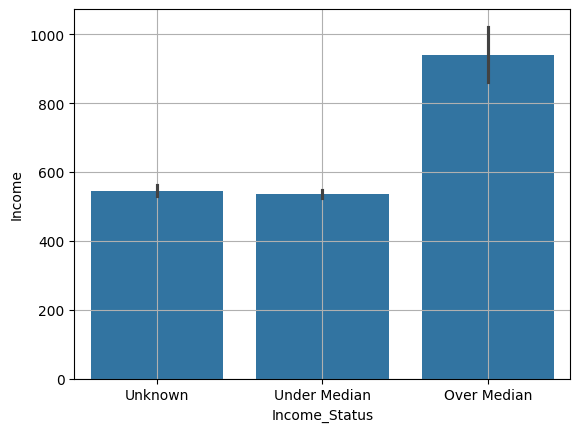

ANOVA result for Income_Status: F-statistic: 117.82006104743407, p-value: 1.3506088832624349e-51


In [93]:
feature = 'Income_Status'

eda_2_cn_anova(train, feature, target)

유의미 : Gender, Education_Status, Employment_Status, Industry_Status, Occupation_Status, Hispanic_Origin, Martial_Status, Household_Status, Household_Summary, Citizenship, Tax_Status, Income_Status

## 3. 데이터 전처리

In [243]:
def data_preprocess(train, test):
    # 1. 열 삭제
    drop_cols = ['ID']
    train.drop(drop_cols, axis=1, inplace=True)
    test_x = test.drop(drop_cols, axis=1)

    # 2. 데이터 분리
    target = 'Income'
    train_x = train.drop(target, axis = 1)
    train_y = train[target]
    
    # 3. Label Encoding
    encoding_target = list(train_x.dtypes[train_x.dtypes == "object"].index)
    for i in encoding_target:
        le = LabelEncoder()
        
        train_x[i] = train_x[i].astype(str)
        test_x[i] = test_x[i].astype(str)
        
        le.fit(train_x[i])
        train_x[i] = le.transform(train_x[i])
        
        for case in np.unique(test_x[i]):
            if case not in le.classes_: 
                le.classes_ = np.append(le.classes_, case)
        
        test_x[i] = le.transform(test_x[i])

    return train_x, train_y, test_x

In [244]:
train_x, train_y, test_x = data_preprocess(train, test)

In [245]:
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42)

def objective(trial):
    
    param = {
        'metric': 'rmse', 
        'random_state': 42,
        'n_estimators': trial.suggest_categorical('n_estimators', [50, 100, 200, 300]),  
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
        'max_depth': trial.suggest_categorical('max_depth', [10,20,100]),
        'num_leaves' : trial.suggest_int('num_leaves', 1, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'cat_smooth' : trial.suggest_int('min_data_per_groups', 1, 100), 
        'device' : 'gpu', 
        'verbose' : -1
    }
    model = LGBMRegressor(**param)  
    
    model.fit(train_x,train_y,eval_set=[(val_x,val_y)]) 
    
    preds = model.predict(val_x) 
    
    rmse = mean_squared_error(val_y, preds,squared=False)  
    
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2024-04-08 04:01:21,998] A new study created in memory with name: no-name-0b409065-6e34-4d00-b972-2151ff333263
[I 2024-04-08 04:01:22,371] Trial 0 finished with value: 595.8425873533138 and parameters: {'n_estimators': 100, 'reg_alpha': 0.14022497404165696, 'reg_lambda': 6.969503482967984, 'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.02, 'max_depth': 20, 'num_leaves': 17, 'min_child_samples': 261, 'min_data_per_groups': 91}. Best is trial 0 with value: 595.8425873533138.
[I 2024-04-08 04:01:24,103] Trial 1 finished with value: 588.8064998493094 and parameters: {'n_estimators': 300, 'reg_alpha': 1.6111243783494238, 'reg_lambda': 0.0012308872902590169, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.017, 'max_depth': 100, 'num_leaves': 497, 'min_child_samples': 257, 'min_data_per_groups': 5}. Best is trial 1 with value: 588.8064998493094.
[I 2024-04-08 04:01:26,193] Trial 2 finished with value: 587.5201911447234 and parameters: {'n_estimators': 300, 'reg

Number of finished trials: 50
Best trial: {'n_estimators': 200, 'reg_alpha': 0.0236010105135775, 'reg_lambda': 1.9211070770355954, 'colsample_bytree': 0.4, 'subsample': 0.4, 'learning_rate': 0.02, 'max_depth': 10, 'num_leaves': 214, 'min_child_samples': 39, 'min_data_per_groups': 85}


In [233]:
study.best_trial.params

{'n_estimators': 300,
 'reg_alpha': 0.2106704658886604,
 'reg_lambda': 0.05243940494194515,
 'colsample_bytree': 0.6,
 'subsample': 1.0,
 'learning_rate': 0.017,
 'max_depth': 10,
 'num_leaves': 145,
 'min_child_samples': 100,
 'min_data_per_groups': 75}

In [237]:
best_params1 = {'n_estimators': 300, 'reg_alpha': 0.2106704658886604, 'reg_lambda': 0.05243940494194515, 'colsample_bytree': 0.6, 'subsample': 1.0,
                'learning_rate': 0.017, 'max_depth': 10, 'num_leaves': 145, 'min_child_samples': 100, 'min_data_per_groups': 75, 'metric': 'rmse', 
                'random_state': 42,'device' : 'gpu', 'verbose' : -1}

In [246]:
best_params2 ={'n_estimators': 200, 'reg_alpha': 0.0236010105135775, 'reg_lambda': 1.9211070770355954, 'colsample_bytree': 0.4, 'subsample': 0.4, 
               'learning_rate': 0.02, 'max_depth': 10, 'num_leaves': 214, 'min_child_samples': 39, 'min_data_per_groups': 85, 'metric': 'rmse', 
                'random_state': 42,'device' : 'gpu', 'verbose' : -1}

## 4. 모델링

### 1. RandomizedSearchCV

In [209]:
def perform_random_search(model, param_dist, X, y, scoring, cv=5, n_iter=10, random_state=42):
    random_search = RandomizedSearchCV(model, param_dist, n_iter=n_iter, scoring=scoring, cv=cv, random_state=random_state)
    random_search.fit(X, y)

    print(f"{model.__class__.__name__} Best Parameters: {random_search.best_params_}")
    print(f"{model.__class__.__name__} Best RMSE: {np.sqrt(-random_search.best_score_)}")

models = {
    # 'RandomForest': (RandomForestRegressor(), {'n_estimators': [50, 100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}),
    # 'XGBoost': (XGBRegressor(), {'n_estimators': [50, 100, 200, 300], 'learning_rate': [0.01, 0.1, 0.2, 0.5], 'max_depth': [3, 5, 7, 10], 'subsample': [0.8, 0.9, 1.0], 'colsample_bytree': [0.8, 0.9, 1.0]}),
    'LightGBM': (LGBMRegressor(verbose=-1), {'n_estimators': [50, 100, 200, 300], 'learning_rate': [0.01, 0.1, 0.2, 0.5], 'max_depth': [3, 5, 7, 10], 'subsample': [0.8, 0.9, 1.0], 'colsample_bytree': [0.8, 0.9, 1.0]}),
    # 'CatBoost': (CatBoostRegressor(silent=True), {'iterations': [50, 100, 200, 300], 'learning_rate': [0.01, 0.1, 0.2, 0.5], 'depth': [3, 5, 7, 10]})
}

In [210]:
# Perform random search for each model
for model_name, (model, param_dist) in models.items():
    perform_random_search(model, param_dist, train_x, train_y, scoring='neg_mean_squared_error', n_iter=20)

LGBMRegressor Best Parameters: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
LGBMRegressor Best RMSE: 593.8355094903277


In [161]:
model_rf = RandomForestRegressor(n_estimators=50, min_samples_split=10, min_samples_leaf=2, max_depth=10, random_state=42)
model_lgb = LGBMRegressor(subsample=0.9, n_estimators=50, max_depth=7, learning_rate=0.2, colsample_bytree=0.8, verbose=-1, random_state=42)
model_xgb = XGBRegressor(subsample=0.8, n_estimators=100, max_depth=3, learning_rate=0.1, colsample_bytree=1.0, random_state=42)
model_cat = CatBoostRegressor(learning_rate=0.1, iterations=200, depth=3, silent=True, random_state=42)

In [16]:
# 변수의 특성 중요도 계산하기
def plot_feature_importance(importance, names, result_only = False, topn = 'all'):
    feature_importance = np.array(importance)
    feature_name = np.array(names)

    data={'feature_name':feature_name,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    #변수의 특성 중요도 순으로 정렬하기
    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    #변수의 특성 중요도 그래프로 그리기
    if result_only == False :
        plt.figure(figsize=(10,20))
        sns.barplot(x='feature_importance', y='feature_name', data = fi_df)

        plt.xlabel('importance')
        plt.ylabel('feature name')
        plt.grid()

    return fi_df

최고 성능 파라미터 저장

### 2. 기본 모델링

In [172]:
models = {
    'RandomForest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42),
    'LightGBM': LGBMRegressor(verbose=-1, random_state=42),
    'CatBoost': CatBoostRegressor(verbose=0, random_state=42)
}

In [169]:
def rmsle_cv(model, X, y, n_folds=5, random_state=42):
    kf = KFold(n_folds, shuffle=True, random_state=random_state)
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kf))
    return rmse

In [170]:
def modeling(models):
    result={}
    for m_name, model in models.items():
        rmse = rmsle_cv(model, train_x_s, train_y, n_folds=5, random_state=42)
        result[m_name] = rmse.mean()
    return result

RandomForest 644.827
XGBoost 627.89
LightGBM 597.114
CatBoost 603.966


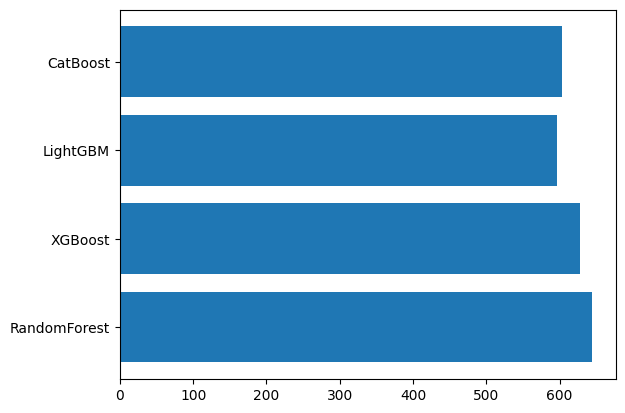

In [173]:
result = modeling(models)

print('=' * 40)
for m_name, score in result.items():
    print(m_name, score.round(3))
print('=' * 40)
# 성능 시각화 비교
plt.barh(list(result.keys()), result.values())
plt.show()

In [176]:
model_lgb.fit(train_x, train_y)

LGBMRegressor(colsample_bytree=0.8, learning_rate=0.2, max_depth=7,
              n_estimators=50, random_state=42, subsample=0.9, verbose=-1)

In [177]:
lgb = plot_feature_importance(model_lgb.feature_importances_, list(train_x), True)
lgb.head()

,feature_name,feature_importance
0,Industry_Status,306
1,Occupation_Status,218
2,Education_Status,203
3,Working_Week (Yearly),142
4,Employment_Status,124


In [182]:
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42)

In [183]:
acc = []
for i in range(14) :   
    top_n_feature = lgb.loc[:i, 'feature_name']
    X_train_n = train_x[top_n_feature]
    X_val_n = val_x[top_n_feature]
    model_lgb.fit(X_train_n, train_y)
    pred = model_lgb.predict(X_val_n)
    acc.append((mean_squared_error(val_y, pred, squared=False)))

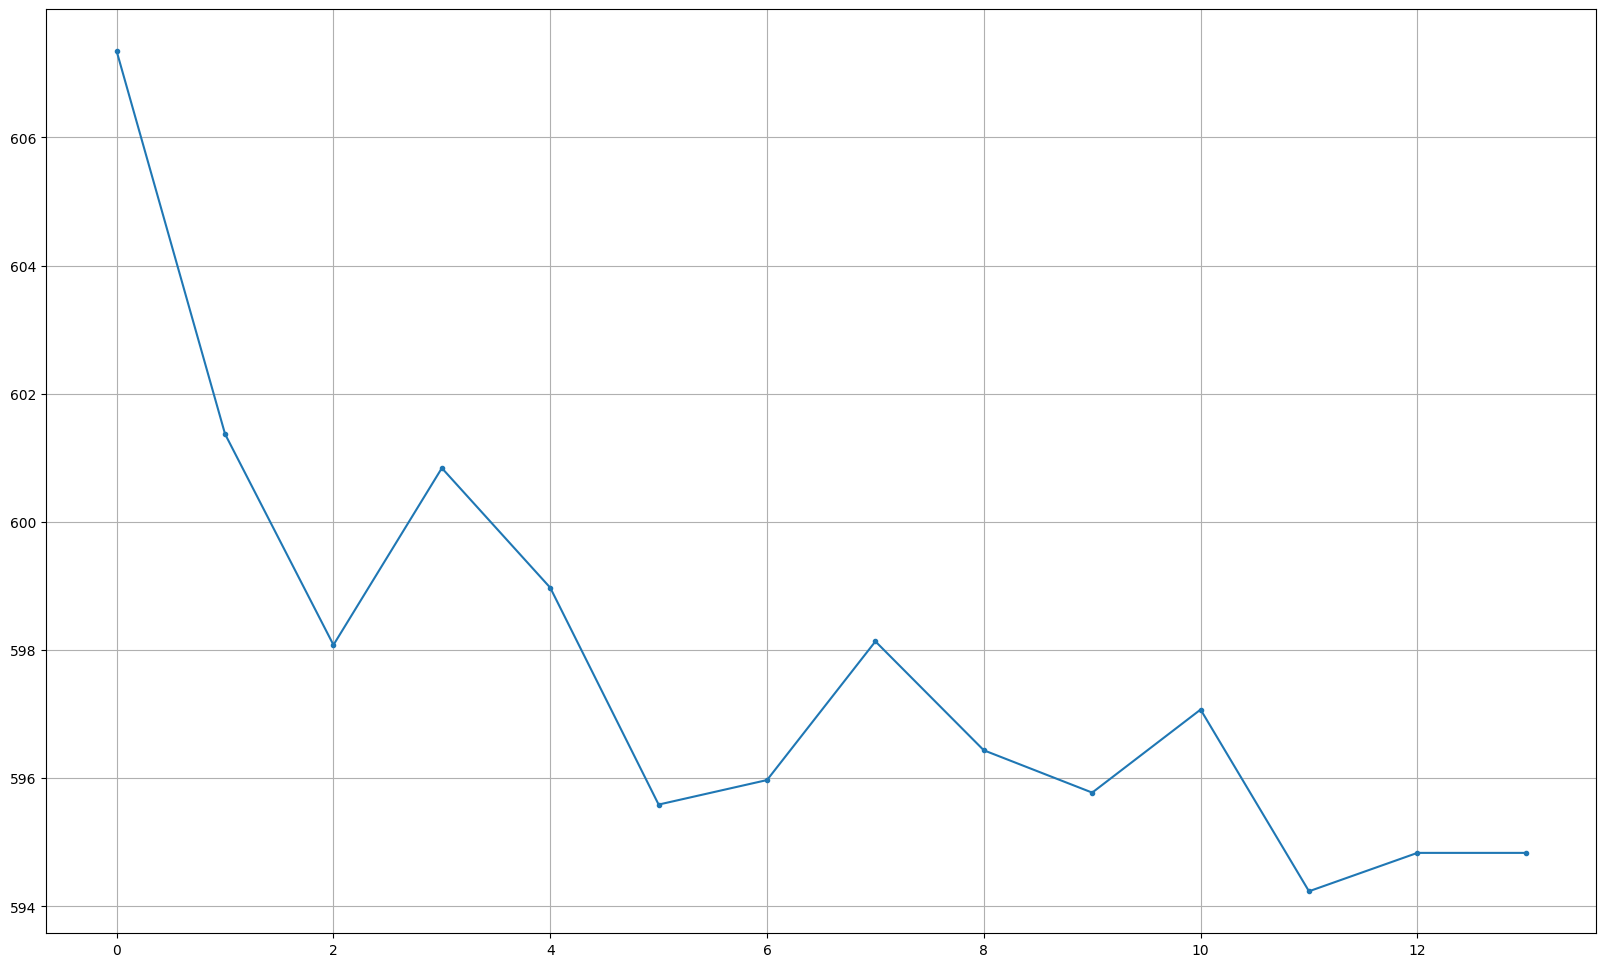

In [184]:
plt.figure(figsize = (20,12))
plt.plot(range(14), acc, marker = '.')
plt.grid()
plt.show()

In [198]:
model_lgb = LGBMRegressor(subsample=0.9, n_estimators=50, max_depth=7, learning_rate=0.2, colsample_bytree=0.8, verbose=-1, random_state=42)
X_train_11 = train_x[top_11_feature]
score = rmsle_cv(model_lgb, X_train_11, train_y, n_folds=5, random_state=42)
print(score.mean())

597.0369145598871


In [200]:
X_train_11.shape

(20000, 12)

In [190]:
top_11_feature = lgb.loc[:11, 'feature_name']
X_train_11 = train_x[top_11_feature]
X_val_11 = val_x[top_11_feature]

model_lgb.fit(X_train_11, train_y)
pred = model_lgb.predict(X_val_11)
print(mean_squared_error(val_y, pred, squared=False))

594.236323795941


In [186]:
top_11_feature

0           Industry_Status
1         Occupation_Status
2          Education_Status
3     Working_Week (Yearly)
4         Employment_Status
5          Household_Status
6             Income_Status
7            Martial_Status
8           Hispanic_Origin
9                Tax_Status
10              Citizenship
11                   Gender
Name: feature_name, dtype: object

In [247]:
model_lgb = LGBMRegressor(**best_params2)
model_lgb.fit(train_x, train_y)
pred5 = model_lgb.predict(test_x)

In [248]:
joblib.dump(model_lgb, 'LightGBM_pred5.pkl')

['LightGBM_pred5.pkl']

In [19]:
sub['Income'] = pred
sub.head()

,ID,Income
0,TEST_0000,2.016934
1,TEST_0001,-7.355236
2,TEST_0002,439.014518
3,TEST_0003,658.105643
4,TEST_0004,-4.272957


In [21]:
sub.to_csv('open/submission1.csv', index=False)

In [249]:
sub['Income'] = pred5
sub.to_csv('open/submission5.csv', index=False)
sub.head()

,ID,Income
0,TEST_0000,29.251085
1,TEST_0001,33.566861
2,TEST_0002,417.682871
3,TEST_0003,631.361814
4,TEST_0004,7.706423
